General Settings

In [1]:
import os
WORKER_POOL_SIZE = 6

TARGET_VOXEL_MM = 1.00
MEAN_PIXEL_VALUE_NODULE = 41
LUNA_SUBSET_START_INDEX = 0
SEGMENTER_IMG_SIZE = 320

BASE_DIR_SSD = "F:/Cengiz/Lung Nodules Detection/Nodule Detection Project 2021/output/"
BASE_DIR = "F:/Cengiz/Lung Nodules Detection/Nodule Detection Project 2020/werkdata/kaggle/ndsb3/"
EXTRA_DATA_DIR = "resources/"
NDSB3_RAW_SRC_DIR = BASE_DIR + "ndsb_raw/stage12/"
LUNA16_RAW_SRC_DIR = BASE_DIR + "luna_raw/"

NDSB3_EXTRACTED_IMAGE_DIR = BASE_DIR_SSD + "ndsb3_extracted_images/"
LUNA16_EXTRACTED_IMAGE_DIR = BASE_DIR_SSD + "luna16_extracted_images/"
NDSB3_NODULE_DETECTION_DIR = BASE_DIR_SSD + "ndsb3_nodule_predictions/"

In [2]:
import glob
import datetime
import sys
import numpy
import cv2
from collections import defaultdict
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import disk, dilation, binary_erosion, binary_closing
from skimage.filters import roberts, sobel
from scipy import ndimage as ndi
import math
import pandas
import ntpath
import SimpleITK
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import random


In [3]:
def rescale_patient_images(images_zyx, org_spacing_xyz, target_voxel_mm, is_mask_image=False, verbose=False):
    if verbose:
        print("Spacing: ", org_spacing_xyz)
        print("Shape: ", images_zyx.shape)

    # print "Resizing dim z"
    resize_x = 1.0
    resize_y = float(org_spacing_xyz[2]) / float(target_voxel_mm)
    interpolation = cv2.INTER_NEAREST if is_mask_image else cv2.INTER_LINEAR
    res = cv2.resize(images_zyx, dsize=None, fx=resize_x, fy=resize_y, interpolation=interpolation)  # opencv assumes y, x, channels umpy array, so y = z pfff
    # print "Shape is now : ", res.shape

    res = res.swapaxes(0, 2)
    res = res.swapaxes(0, 1)
    # print "Shape: ", res.shape
    resize_x = float(org_spacing_xyz[0]) / float(target_voxel_mm)
    resize_y = float(org_spacing_xyz[1]) / float(target_voxel_mm)

    # cv2 can handle max 512 channels..
    if res.shape[2] > 512:
        res = res.swapaxes(0, 2)
        res1 = res[:256]
        res2 = res[256:]
        res1 = res1.swapaxes(0, 2)
        res2 = res2.swapaxes(0, 2)
        res1 = cv2.resize(res1, dsize=None, fx=resize_x, fy=resize_y, interpolation=interpolation)
        res2 = cv2.resize(res2, dsize=None, fx=resize_x, fy=resize_y, interpolation=interpolation)
        res1 = res1.swapaxes(0, 2)
        res2 = res2.swapaxes(0, 2)
        res = numpy.vstack([res1, res2])
        res = res.swapaxes(0, 2)
    else:
        res = cv2.resize(res, dsize=None, fx=resize_x, fy=resize_y, interpolation=interpolation)

    # channels = cv2.split(res)
    # resized_channels = []
    # for channel in  channels:
    #     channel = cv2.resize(channel, dsize=None, fx=resize_x, fy=resize_y)
    #     resized_channels.append(channel)
    # res = cv2.merge(resized_channels)
    # print "Shape after resize: ", res.shape
    res = res.swapaxes(0, 2)
    res = res.swapaxes(2, 1)
    if verbose:
        print("Shape after: ", res.shape)
    return res
def load_patient_images(patient_id, base_dir=None, wildcard="*.*", exclude_wildcards=[]):
    if base_dir == None:
        base_dir = LUNA_16_TRAIN_DIR
    src_dir = base_dir + patient_id + "/"
    src_img_paths = glob.glob(src_dir + wildcard)
    for exclude_wildcard in exclude_wildcards:
        exclude_img_paths = glob.glob(src_dir + exclude_wildcard)
        src_img_paths = [im for im in src_img_paths if im not in exclude_img_paths]
    src_img_paths.sort()
    images = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in src_img_paths]
    images = [im.reshape((1, ) + im.shape) for im in images]
    res = numpy.vstack(images)
    return res
def print_tabbed(value_list, justifications=None, map_id=None, show_map_idx=True):
    map_entries = None
    if map_id is not None:
        map_entries = PRINT_TAB_MAP[map_id]

    if map_entries is not None and show_map_idx:
        idx = str(len(map_entries))
        if idx == "0":
            idx = "idx"
        value_list.insert(0, idx)
        if justifications is not None:
            justifications.insert(0, 6)

    value_list = [str(v) for v in value_list]
    if justifications is not None:
        new_list = []
        assert(len(value_list) == len(justifications))
        for idx, value in enumerate(value_list):
            str_value = str(value)
            just = justifications[idx]
            if just > 0:
                new_value = str_value.ljust(just)
            else:
                new_value = str_value.rjust(just)
            new_list.append(new_value)

        value_list = new_list

    line = "\t".join(value_list)
    if map_entries is not None:
        map_entries.append(line)
    print(line)

In [4]:
def get_segmented_lungs(im, plot=False):
    # Step 1: Convert into a binary image.
    binary = im < -400
    # Step 2: Remove the blobs connected to the border of the image.
    cleared = clear_border(binary)
    # Step 3: Label the image.
    label_image = label(cleared)
    # Step 4: Keep the labels with 2 largest areas.
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    # Step 5: Erosion operation with a disk of radius 2. This operation is seperate the lung nodules attached to the blood vessels.
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    # Step 6: Closure operation with a disk of radius 10. This operation is    to keep nodules attached to the lung wall.
    selem = disk(10) # CHANGE BACK TO 10
    binary = binary_closing(binary, selem)
    # Step 7: Fill in the small holes inside the binary mask of lungs.
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    # Step 8: Superimpose the binary mask on the input image.
    get_high_vals = binary == 0
    im[get_high_vals] = -2000
    return im, binary

Step One: Preprocess LUNA16 Dataset

In [5]:
only_process_patient = "1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860"
src_dir = LUNA16_RAW_SRC_DIR #+ "subset" + str(subject_no) + "/"
src_paths = glob.glob(src_dir + "*.mhd")

In [8]:
patient_id = ""
src_path = ""
for src_path in src_paths:
    if only_process_patient is not None:
        if only_process_patient not in src_path:
            continue
    patient_id = ntpath.basename(src_path).replace(".mhd", "")

print("Patient: ", patient_id)

dst_dir = LUNA16_EXTRACTED_IMAGE_DIR + patient_id + "/"
if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)

itk_img = SimpleITK.ReadImage(src_path)
img_array = SimpleITK.GetArrayFromImage(itk_img)
print("Img array: ", img_array.shape)

origin = numpy.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
print("Origin (x,y,z): ", origin)

direction = numpy.array(itk_img.GetDirection())      # x,y,z  Origin in world coordinates (mm)
print("Direction: ", direction)


spacing = numpy.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
print("Spacing (x,y,z): ", spacing)
rescale = spacing / TARGET_VOXEL_MM
print("Rescale: ", rescale)

img_array = rescale_patient_images(img_array, spacing, TARGET_VOXEL_MM,verbose=True)
def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

img_list = []
mask = []
img_orignal = []
img_norm = []
for i in range(img_array.shape[0]):
    img = img_array[i]
    seg_img, mask = get_segmented_lungs(img.copy())
    img_list.append(seg_img)
    img_orignal.append(img)
    img = normalize(img)
    img_norm.append(img)
    cv2.imwrite(dst_dir + "img_" + str(i).rjust(4, '0') + "_i.png", img * 255)
    cv2.imwrite(dst_dir + "img_" + str(i).rjust(4, '0') + "_m.png", mask * 255)

Patient:  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
Img array:  (285, 512, 512)
Origin (x,y,z):  [-155.199997 -142.199997 -316.609985]
Direction:  [1. 0. 0. 0. 1. 0. 0. 0. 1.]
Spacing (x,y,z):  [0.58593798 0.58593798 1.25      ]
Rescale:  [0.58593798 0.58593798 1.25      ]
Spacing:  [0.58593798 0.58593798 1.25      ]
Shape:  (285, 512, 512)
Shape after:  (356, 300, 300)


Display Random Images


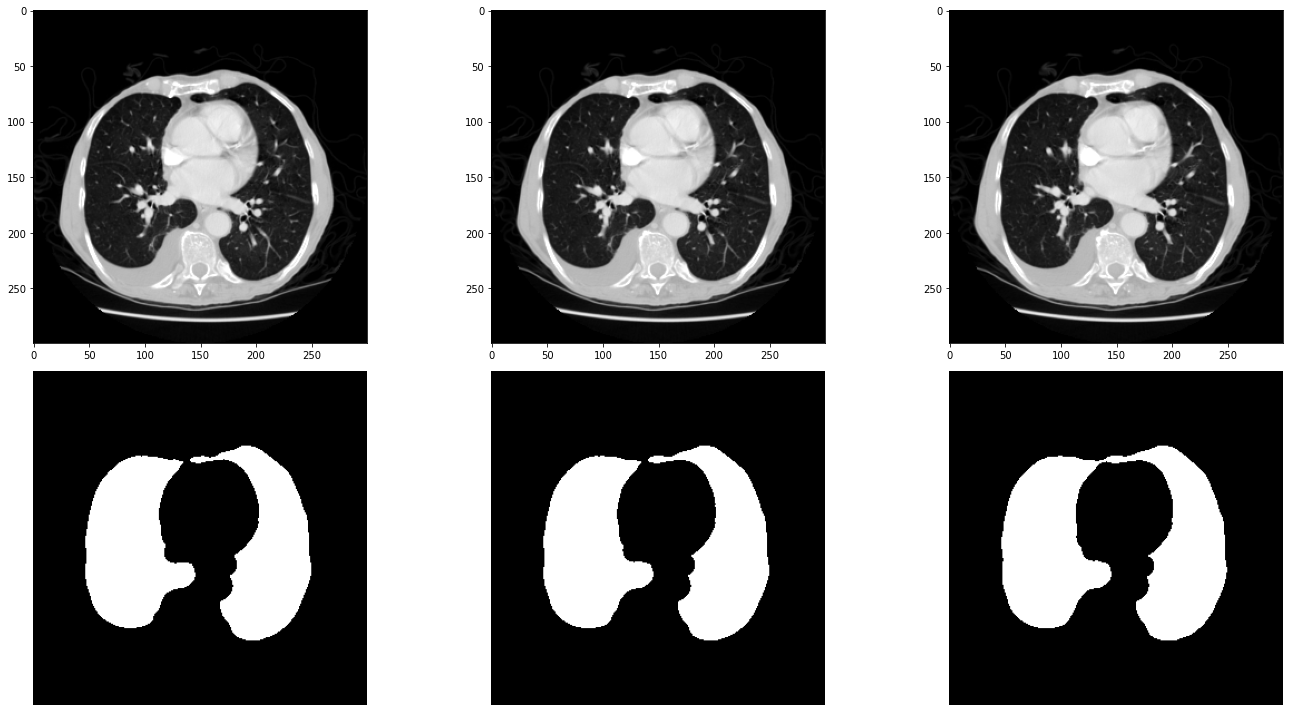

In [9]:
print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(3):
    plt.subplot(2, 3, i + 1)
    img_name = "img_" + str(i+200).rjust(4, '0') + "_i.png"
    mask_name = "img_" + str(i+200).rjust(4, '0') + "_m.png"
    img = plt.imread(os.path.join(dst_dir, img_name))
    plt.imshow(img, cmap='gray')
    plt.subplot(2, 3, i + 1+3)
    img = plt.imread(os.path.join(dst_dir, mask_name))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

(300, 300)


True

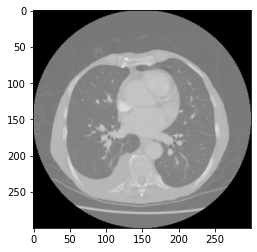

In [23]:
print(img_orignal[200].shape)
plt.imshow(img_orignal[200], cmap='gray')

cv2.imwrite("img_" + str(i).rjust(4, '0') + "_original.png", img_orignal[200])
cv2.imwrite("img_" + str(i).rjust(4, '0') + "_norm.png", img_norm[200] * 255)

step 2 Process LIDC annotation...

In [20]:
def load_lidc_xml(xml_path, agreement_threshold=0, only_patient=None, save_nodules=False):
    pos_lines = []
    neg_lines = []
    extended_lines = []
    with open(xml_path, 'r') as xml_file:
        markup = xml_file.read()
    xml = BeautifulSoup(markup, features="xml")
    if xml.LidcReadMessage is None:
        return None, None, None
    patient_id = xml.LidcReadMessage.ResponseHeader.SeriesInstanceUid.text

    if only_patient is not None:
        if only_patient != patient_id:
            print (patient_id)
            return None, None, None

    src_path = find_mhd_file(patient_id)
    if src_path is None:
        return None, None, None

    print(patient_id)
    itk_img = SimpleITK.ReadImage(src_path)
    img_array = SimpleITK.GetArrayFromImage(itk_img)
    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    origin = numpy.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = numpy.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    rescale = spacing / TARGET_VOXEL_MM

    reading_sessions = xml.LidcReadMessage.find_all("readingSession")
    for reading_session in reading_sessions:
        # print("Sesion")
        nodules = reading_session.find_all("unblindedReadNodule")
        for nodule in nodules:
            nodule_id = nodule.noduleID.text
            # print("  ", nodule.noduleID)
            rois = nodule.find_all("roi")
            x_min = y_min = z_min = 999999
            x_max = y_max = z_max = -999999
            if len(rois) < 2:
                continue

            for roi in rois:
                z_pos = float(roi.imageZposition.text)
                z_min = min(z_min, z_pos)
                z_max = max(z_max, z_pos)
                edge_maps = roi.find_all("edgeMap")
                for edge_map in edge_maps:
                    x = int(edge_map.xCoord.text)
                    y = int(edge_map.yCoord.text)
                    x_min = min(x_min, x)
                    y_min = min(y_min, y)
                    x_max = max(x_max, x)
                    y_max = max(y_max, y)
                if x_max == x_min:
                    continue
                if y_max == y_min:
                    continue

            x_diameter = x_max - x_min
            x_center = x_min + x_diameter / 2
            y_diameter = y_max - y_min
            y_center = y_min + y_diameter / 2
            z_diameter = z_max - z_min
            z_center = z_min + z_diameter / 2
            z_center -= origin[2]
            z_center /= spacing[2]

            x_center_perc = round(x_center / img_array.shape[2], 4)
            y_center_perc = round(y_center / img_array.shape[1], 4)
            z_center_perc = round(z_center / img_array.shape[0], 4)
            diameter = max(x_diameter , y_diameter)
            diameter_perc = round(max(x_diameter / img_array.shape[2], y_diameter / img_array.shape[1]), 4)

            if nodule.characteristics is None:
                print("!!!!Nodule:", nodule_id, " has no charecteristics")
                continue
            if nodule.characteristics.malignancy is None:
                print("!!!!Nodule:", nodule_id, " has no malignacy")
                continue

            malignacy = nodule.characteristics.malignancy.text
            sphericiy = nodule.characteristics.sphericity.text
            margin = nodule.characteristics.margin.text
            spiculation = nodule.characteristics.spiculation.text
            texture = nodule.characteristics.texture.text
            calcification = nodule.characteristics.calcification.text
            internal_structure = nodule.characteristics.internalStructure.text
            lobulation = nodule.characteristics.lobulation.text
            subtlety = nodule.characteristics.subtlety.text

            line = [nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy]
            extended_line = [patient_id, nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy, sphericiy, margin, spiculation, texture, calcification, internal_structure, lobulation, subtlety ]
            pos_lines.append(line)
            extended_lines.append(extended_line)

        nonNodules = reading_session.find_all("nonNodule")
        for nonNodule in nonNodules:
            z_center = float(nonNodule.imageZposition.text)
            z_center -= origin[2]
            z_center /= spacing[2]
            x_center = int(nonNodule.locus.xCoord.text)
            y_center = int(nonNodule.locus.yCoord.text)
            nodule_id = nonNodule.nonNoduleID.text
            x_center_perc = round(x_center / img_array.shape[2], 4)
            y_center_perc = round(y_center / img_array.shape[1], 4)
            z_center_perc = round(z_center / img_array.shape[0], 4)
            diameter_perc = round(max(6 / img_array.shape[2], 6 / img_array.shape[1]), 4)
            # print("Non nodule!", z_center)
            line = [nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, 0]
            neg_lines.append(line)

    if agreement_threshold > 1:
        filtered_lines = []
        for pos_line1 in pos_lines:
            id1 = pos_line1[0]
            x1 = pos_line1[1]
            y1 = pos_line1[2]
            z1 = pos_line1[3]
            d1 = pos_line1[4]
            overlaps = 0
            for pos_line2 in pos_lines:
                id2 = pos_line2[0]
                if id1 == id2:
                    continue
                x2 = pos_line2[1]
                y2 = pos_line2[2]
                z2 = pos_line2[3]
                d2 = pos_line1[4]
                dist = math.sqrt(math.pow(x1 - x2, 2) + math.pow(y1 - y2, 2) + math.pow(z1 - z2, 2))
                if dist < d1 or dist < d2:
                    overlaps += 1
            if overlaps >= agreement_threshold:
                filtered_lines.append(pos_line1)
            # else:
            #     print("Too few overlaps")
        pos_lines = filtered_lines

    df_annos = pandas.DataFrame(pos_lines, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_annos.to_csv(LUNA16_EXTRACTED_IMAGE_DIR + "_labels/" + patient_id + "_annos_pos_lidc.csv", index=False)
    df_neg_annos = pandas.DataFrame(neg_lines, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_neg_annos.to_csv(LUNA16_EXTRACTED_IMAGE_DIR + "_labels/" + patient_id + "_annos_neg_lidc.csv", index=False)

    # return [patient_id, spacing[0], spacing[1], spacing[2]]
    return pos_lines, neg_lines, extended_lines

In [24]:
def find_mhd_file(patient_id):
    # for subject_no in range(LUNA_SUBSET_START_INDEX, 10):
    src_dir = LUNA16_RAW_SRC_DIR  # + "subset" + str(subject_no) + "/"
    src_paths = glob.glob(src_dir + "*.mhd")
    for src_path in glob.glob(src_dir + "*.mhd"):
        if patient_id in src_path:
            return src_path
    return None

file_no = 0
pos_count = 0
neg_count = 0
all_lines = []
only_patient = "1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860"
agreement_threshold=0
for anno_dir in [d for d in glob.glob("resources/luna16_annotations/188") if os.path.isdir(d)]:
    xml_paths = glob.glob(anno_dir + "/104.xml")
    for xml_path in xml_paths:
        print(file_no, ": ",  xml_path)
        pos, neg, extended = load_lidc_xml(xml_path=xml_path, only_patient=only_patient, agreement_threshold=agreement_threshold)
        if pos is not None:
            pos_count += len(pos)
            neg_count += len(neg)
            print("Pos: ", pos_count, " Neg: ", neg_count)
            file_no += 1
            all_lines += extended
        # if file_no > 10:
        #     break

        # extended_line = [nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy, sphericiy, margin, spiculation, texture, calcification, internal_structure, lobulation, subtlety ]
df_annos = pandas.DataFrame(all_lines, columns=["patient_id", "anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore", "sphericiy", "margin", "spiculation", "texture", "calcification", "internal_structure", "lobulation", "subtlety"])
df_annos.to_csv(BASE_DIR + "lidc_annotations.csv", index=False)

0 :  resources/luna16_annotations/188/104.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
Pos:  7  Neg:  55


Pos Annotation

In [34]:
file_no = 0
pos_count = 0
neg_count = 0
all_lines = []
only_patient = "1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860"
agreement_threshold=0
for anno_dir in [d for d in glob.glob("resources/luna16_annotations/188/*") if os.path.isdir(d)]:
    xml_paths = glob.glob(anno_dir + "/*.xml")
    for xml_path in xml_paths:
        print(file_no, ": ",  xml_path)
        pos, neg, extended = load_lidc_xml(xml_path=xml_path, only_patient=only_patient, agreement_threshold=agreement_threshold)
        if pos is not None:
            pos_count += len(pos)
            neg_count += len(neg)
            print("Pos: ", pos_count, " Neg: ", neg_count)
            file_no += 1
            all_lines += extended
        # if file_no > 10:
        #     break

        # extended_line = [nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy, sphericiy, margin, spiculation, texture, calcification, internal_structure, lobulation, subtlety ]
df_annos = pandas.DataFrame(all_lines, columns=["patient_id", "anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore", "sphericiy", "margin", "spiculation", "texture", "calcification", "internal_structure", "lobulation", "subtlety"])
df_annos.to_csv(BASE_DIR + "lidc_annotations.csv", index=False)

In [35]:
def process_pos_annotations_patient(src_path, patient_id):
    df_node = pandas.read_csv("resources/luna16_annotations/annotations.csv")
    dst_dir = LUNA16_EXTRACTED_IMAGE_DIR + "_labels/"
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)
    dst_dir = dst_dir + patient_id + "/"
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)
    itk_img = SimpleITK.ReadImage(src_path)
    img_array = SimpleITK.GetArrayFromImage(itk_img)
    print("Img array: ", img_array.shape)
    df_patient = df_node[df_node["seriesuid"] == patient_id]
    print("Annos: ", len(df_patient))

    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    origin = numpy.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    print("Origin (x,y,z): ", origin)
    spacing = numpy.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    print("Spacing (x,y,z): ", spacing)
    rescale = spacing /TARGET_VOXEL_MM
    print("Rescale: ", rescale)

    direction = numpy.array(itk_img.GetDirection())      # x,y,z  Origin in world coordinates (mm)
    print("Direction: ", direction)
    flip_direction_x = False
    flip_direction_y = False
    if round(direction[0]) == -1:
        origin[0] *= -1
        direction[0] = 1
        flip_direction_x = True
        print("Swappint x origin")
    if round(direction[4]) == -1:
        origin[1] *= -1
        direction[4] = 1
        flip_direction_y = True
        print("Swappint y origin")
    print("Direction: ", direction)
    assert abs(sum(direction) - 3) < 0.01

    patient_imgs = load_patient_images(patient_id, LUNA16_EXTRACTED_IMAGE_DIR, "*_i.png")

    pos_annos = []
    df_patient = df_node[df_node["seriesuid"] == patient_id]
    anno_index = 0
    for index, annotation in df_patient.iterrows():
        node_x = annotation["coordX"]
        if flip_direction_x:
            node_x *= -1
        node_y = annotation["coordY"]
        if flip_direction_y:
            node_y *= -1
        node_z = annotation["coordZ"]
        diam_mm = annotation["diameter_mm"]
        print("Node org (x,y,z,diam): ", (round(node_x, 2), round(node_y, 2), round(node_z, 2), round(diam_mm, 2)))
        center_float = numpy.array([node_x, node_y, node_z])
        center_int = numpy.rint((center_float-origin) / spacing)
        # center_int = numpy.rint((center_float - origin) )
        print("Node tra (x,y,z,diam): ", (center_int[0], center_int[1], center_int[2]))
        # center_int_rescaled = numpy.rint(((center_float-origin) / spacing) * rescale)
        center_float_rescaled = (center_float - origin) / TARGET_VOXEL_MM
        center_float_percent = center_float_rescaled / patient_imgs.swapaxes(0, 2).shape
        # center_int = numpy.rint((center_float - origin) )
        print("Node sca (x,y,z,diam): ", (center_float_rescaled[0], center_float_rescaled[1], center_float_rescaled[2]))
        diameter_pixels = diam_mm / TARGET_VOXEL_MM
        diameter_percent = diameter_pixels / float(patient_imgs.shape[1])

        pos_annos.append([anno_index, round(center_float_percent[0], 4), round(center_float_percent[1], 4), round(center_float_percent[2], 4), round(diameter_percent, 4), 1])
        anno_index += 1

    df_annos = pandas.DataFrame(pos_annos, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_annos.to_csv(LUNA16_EXTRACTED_IMAGE_DIR + "_labels/" + patient_id + "_annos_pos.csv", index=False)
    return [patient_id, spacing[0], spacing[1], spacing[2]]

candidate_index = 0
# for subject_no in range(LUNA_SUBSET_START_INDEX, 10):
src_dir = LUNA16_RAW_SRC_DIR  # + "subset" + str(subject_no) + "/"
for src_path in glob.glob(src_dir + "*.mhd"):
    if only_patient is not None and only_patient not in src_path:
        continue
    patient_id = ntpath.basename(src_path).replace(".mhd", "")
    print(candidate_index, " patient: ", patient_id)
    process_pos_annotations_patient(src_path, patient_id)
    candidate_index += 1

0  patient:  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
Img array:  (194, 512, 512)
Annos:  2
Origin (x,y,z):  [-157.67773 -311.67773 -438.4    ]
Spacing (x,y,z):  [0.64453125 0.64453125 1.79999995]
Rescale:  [0.64453125 0.64453125 1.79999995]
Direction:  [1. 0. 0. 0. 1. 0. 0. 0. 1.]
Direction:  [1. 0. 0. 0. 1. 0. 0. 0. 1.]
Node org (x,y,z,diam):  (-128.7, -175.32, -298.39, 5.65)
Node tra (x,y,z,diam):  (45.0, 212.0, 78.0)
Node sca (x,y,z,diam):  (28.978308900000002, 136.35845819999997, 140.01249360000003)
Node org (x,y,z,diam):  (103.78, -211.93, -227.12, 4.22)
Node tra (x,y,z,diam):  (406.0, 155.0, 117.0)
Node sca (x,y,z,diam):  (261.4613809, 99.75258130000003, 211.27874999999997)


step 4 Process excluded annotation...

In [38]:
def process_excluded_annotations_patient(src_path, patient_id):
    df_node = pandas.read_csv("resources/luna16_annotations/annotations_excluded.csv")
    dst_dir = LUNA16_EXTRACTED_IMAGE_DIR + "_labels/"
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)
    dst_dir = dst_dir + patient_id + "/"
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)

    # pos_annos_df = pandas.read_csv(TRAIN_DIR + "metadata/" + patient_id + "_annos_pos_lidc.csv")
    pos_annos_df = pandas.read_csv(LUNA16_EXTRACTED_IMAGE_DIR + "_labels/" + patient_id + "_annos_pos.csv")
    pos_annos_manual = None
    manual_path = EXTRA_DATA_DIR + "luna16_manual_labels/" + patient_id + ".csv"
    if os.path.exists(manual_path):
        pos_annos_manual = pandas.read_csv(manual_path)
        dmm = pos_annos_manual["dmm"]  # check

    itk_img = SimpleITK.ReadImage(src_path)
    img_array = SimpleITK.GetArrayFromImage(itk_img)
    print("Img array: ", img_array.shape)
    df_patient = df_node[df_node["seriesuid"] == patient_id]
    print("Annos: ", len(df_patient))

    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    origin = numpy.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    print("Origin (x,y,z): ", origin)
    spacing = numpy.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    print("Spacing (x,y,z): ", spacing)
    rescale = spacing / TARGET_VOXEL_MM
    print("Rescale: ", rescale)

    direction = numpy.array(itk_img.GetDirection())      # x,y,z  Origin in world coordinates (mm)
    print("Direction: ", direction)
    flip_direction_x = False
    flip_direction_y = False
    if round(direction[0]) == -1:
        origin[0] *= -1
        direction[0] = 1
        flip_direction_x = True
        print("Swappint x origin")
    if round(direction[4]) == -1:
        origin[1] *= -1
        direction[4] = 1
        flip_direction_y = True
        print("Swappint y origin")
    print("Direction: ", direction)
    assert abs(sum(direction) - 3) < 0.01

    patient_imgs = load_patient_images(patient_id, LUNA16_EXTRACTED_IMAGE_DIR, "*_i.png")

    neg_annos = []
    df_patient = df_node[df_node["seriesuid"] == patient_id]
    anno_index = 0
    for index, annotation in df_patient.iterrows():
        node_x = annotation["coordX"]
        if flip_direction_x:
            node_x *= -1
        node_y = annotation["coordY"]
        if flip_direction_y:
            node_y *= -1
        node_z = annotation["coordZ"]
        center_float = numpy.array([node_x, node_y, node_z])
        center_int = numpy.rint((center_float-origin) / spacing)
        center_float_rescaled = (center_float - origin) / TARGET_VOXEL_MM
        center_float_percent = center_float_rescaled / patient_imgs.swapaxes(0, 2).shape
        # center_int = numpy.rint((center_float - origin) )
        # print("Node sca (x,y,z,diam): ", (center_float_rescaled[0], center_float_rescaled[1], center_float_rescaled[2]))
        diameter_pixels = 6 / TARGET_VOXEL_MM
        diameter_percent = diameter_pixels / float(patient_imgs.shape[1])

        ok = True

        for index, row in pos_annos_df.iterrows():
            pos_coord_x = row["coord_x"] * patient_imgs.shape[2]
            pos_coord_y = row["coord_y"] * patient_imgs.shape[1]
            pos_coord_z = row["coord_z"] * patient_imgs.shape[0]
            diameter = row["diameter"] * patient_imgs.shape[2]
            print((pos_coord_x, pos_coord_y, pos_coord_z))
            print(center_float_rescaled)
            dist = math.sqrt(math.pow(pos_coord_x - center_float_rescaled[0], 2) + math.pow(pos_coord_y - center_float_rescaled[1], 2) + math.pow(pos_coord_z - center_float_rescaled[2], 2))
            if dist < (diameter + 64):  #  make sure we have a big margin
                ok = False
                print("################### Too close", center_float_rescaled)
                break

        if pos_annos_manual is not None and ok:
            for index, row in pos_annos_manual.iterrows():
                pos_coord_x = row["x"] * patient_imgs.shape[2]
                pos_coord_y = row["y"] * patient_imgs.shape[1]
                pos_coord_z = row["z"] * patient_imgs.shape[0]
                diameter = row["d"] * patient_imgs.shape[2]
                print((pos_coord_x, pos_coord_y, pos_coord_z))
                print(center_float_rescaled)
                dist = math.sqrt(math.pow(pos_coord_x - center_float_rescaled[0], 2) + math.pow(pos_coord_y - center_float_rescaled[1], 2) + math.pow(pos_coord_z - center_float_rescaled[2], 2))
                if dist < (diameter + 72):  #  make sure we have a big margin
                    ok = False
                    print("################### Too close", center_float_rescaled)
                    break

        if not ok:
            continue

        neg_annos.append([anno_index, round(center_float_percent[0], 4), round(center_float_percent[1], 4), round(center_float_percent[2], 4), round(diameter_percent, 4), 1])
        anno_index += 1

    df_annos = pandas.DataFrame(neg_annos, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_annos.to_csv(LUNA16_EXTRACTED_IMAGE_DIR + "_labels/" + patient_id + "_annos_excluded.csv", index=False)
    return [patient_id, spacing[0], spacing[1], spacing[2]]


candidate_index = 0
# for subject_no in range(LUNA_SUBSET_START_INDEX, 10):
src_dir = LUNA16_RAW_SRC_DIR  # + "subset" + str(subject_no) + "/"
for src_path in glob.glob(src_dir + "*.mhd"):
    if only_patient is not None and only_patient not in src_path:
        continue
    patient_id = ntpath.basename(src_path).replace(".mhd", "")
    print(candidate_index, " patient: ", patient_id)
    process_excluded_annotations_patient(src_path, patient_id)
    candidate_index += 1

0  patient:  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
Img array:  (194, 512, 512)
Annos:  73
Origin (x,y,z):  [-157.67773 -311.67773 -438.4    ]
Spacing (x,y,z):  [0.64453125 0.64453125 1.79999995]
Rescale:  [0.64453125 0.64453125 1.79999995]
Direction:  [1. 0. 0. 0. 1. 0. 0. 0. 1.]
Direction:  [1. 0. 0. 0. 1. 0. 0. 0. 1.]
(28.98, 136.35, 140.01479999999998)
[ 25.7812355 156.6210285 120.6      ]
################### Too close [ 25.7812355 156.6210285 120.6      ]
(28.98, 136.35, 140.01479999999998)
[238.4764655 202.3827295 315.       ]
(261.45, 99.75, 211.286)
[238.4764655 202.3827295 315.       ]
(28.98, 136.35, 140.01479999999998)
[ 95.3905835 256.5233335 154.8      ]
(261.45, 99.75, 211.286)
[ 95.3905835 256.5233335 154.8      ]
(28.98, 136.35, 140.01479999999998)
[241.0545895 253.3006785 201.6      ]
(261.45, 99.75, 211.286)
[241.0545895 253.3006785 201.6      ]
(28.98, 136.35, 140.01479999999998)
[116.6601065 251.3670855 198.       ]
(261.45, 99.75, 211.286)

In [40]:
def process_luna_candidates_patient(src_path, patient_id):
    dst_dir = LUNA16_EXTRACTED_IMAGE_DIR + "/_labels/"
    img_dir = dst_dir + patient_id + "/"
    df_pos_annos = pandas.read_csv(dst_dir + patient_id + "_annos_pos_lidc.csv")
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)

    pos_annos_manual = None
    manual_path = EXTRA_DATA_DIR + "luna16_manual_labels/" + patient_id + ".csv"
    if os.path.exists(manual_path):
        pos_annos_manual = pandas.read_csv(manual_path)

    itk_img = SimpleITK.ReadImage(src_path)
    img_array = SimpleITK.GetArrayFromImage(itk_img)
    print("Img array: ", img_array.shape)
    print("Pos annos: ", len(df_pos_annos))

    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    origin = numpy.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    print("Origin (x,y,z): ", origin)
    spacing = numpy.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    print("Spacing (x,y,z): ", spacing)
    rescale = spacing / TARGET_VOXEL_MM
    print("Rescale: ", rescale)

    direction = numpy.array(itk_img.GetDirection())      # x,y,z  Origin in world coordinates (mm)
    print("Direction: ", direction)
    flip_direction_x = False
    flip_direction_y = False
    if round(direction[0]) == -1:
        origin[0] *= -1
        direction[0] = 1
        flip_direction_x = True
        print("Swappint x origin")
    if round(direction[4]) == -1:
        origin[1] *= -1
        direction[4] = 1
        flip_direction_y = True
        print("Swappint y origin")
    print("Direction: ", direction)
    assert abs(sum(direction) - 3) < 0.01

    src_df = pandas.read_csv("resources/luna16_annotations/" + "candidates_V2.csv")
    src_df = src_df[src_df["seriesuid"] == patient_id]
    src_df = src_df[src_df["class"] == 0]
    patient_imgs = load_patient_images(patient_id, LUNA16_EXTRACTED_IMAGE_DIR, "*_i.png")
    candidate_list = []

    for df_index, candiate_row in src_df.iterrows():
        node_x = candiate_row["coordX"]
        if flip_direction_x:
            node_x *= -1
        node_y = candiate_row["coordY"]
        if flip_direction_y:
            node_y *= -1
        node_z = candiate_row["coordZ"]
        candidate_diameter = 6
        # print("Node org (x,y,z,diam): ", (round(node_x, 2), round(node_y, 2), round(node_z, 2), round(candidate_diameter, 2)))
        center_float = numpy.array([node_x, node_y, node_z])
        center_int = numpy.rint((center_float-origin) / spacing)
        # center_int = numpy.rint((center_float - origin) )
        # print("Node tra (x,y,z,diam): ", (center_int[0], center_int[1], center_int[2]))
        # center_int_rescaled = numpy.rint(((center_float-origin) / spacing) * rescale)
        center_float_rescaled = (center_float - origin) / TARGET_VOXEL_MM
        center_float_percent = center_float_rescaled / patient_imgs.swapaxes(0, 2).shape
        # center_int = numpy.rint((center_float - origin) )
        # print("Node sca (x,y,z,diam): ", (center_float_rescaled[0], center_float_rescaled[1], center_float_rescaled[2]))
        coord_x = center_float_rescaled[0]
        coord_y = center_float_rescaled[1]
        coord_z = center_float_rescaled[2]

        ok = True

        for index, row in df_pos_annos.iterrows():
            pos_coord_x = row["coord_x"] * patient_imgs.shape[2]
            pos_coord_y = row["coord_y"] * patient_imgs.shape[1]
            pos_coord_z = row["coord_z"] * patient_imgs.shape[0]
            diameter = row["diameter"] * patient_imgs.shape[2]
            dist = math.sqrt(math.pow(pos_coord_x - coord_x, 2) + math.pow(pos_coord_y - coord_y, 2) + math.pow(pos_coord_z - coord_z, 2))
            if dist < (diameter + 64):  #  make sure we have a big margin
                ok = False
                print("################### Too close", (coord_x, coord_y, coord_z))
                break

        if pos_annos_manual is not None and ok:
            for index, row in pos_annos_manual.iterrows():
                pos_coord_x = row["x"] * patient_imgs.shape[2]
                pos_coord_y = row["y"] * patient_imgs.shape[1]
                pos_coord_z = row["z"] * patient_imgs.shape[0]
                diameter = row["d"] * patient_imgs.shape[2]
                print((pos_coord_x, pos_coord_y, pos_coord_z))
                print(center_float_rescaled)
                dist = math.sqrt(math.pow(pos_coord_x - center_float_rescaled[0], 2) + math.pow(pos_coord_y - center_float_rescaled[1], 2) + math.pow(pos_coord_z - center_float_rescaled[2], 2))
                if dist < (diameter + 72):  #  make sure we have a big margin
                    ok = False
                    print("################### Too close", center_float_rescaled)
                    break

        if not ok:
            continue

        candidate_list.append([len(candidate_list), round(center_float_percent[0], 4), round(center_float_percent[1], 4), round(center_float_percent[2], 4), round(candidate_diameter / patient_imgs.shape[0], 4), 0])

    df_candidates = pandas.DataFrame(candidate_list, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_candidates.to_csv(dst_dir + patient_id + "_candidates_luna.csv", index=False)


src_dir = LUNA16_RAW_SRC_DIR  # + "subset" + str(subject_no) + "/"
for patient_index, src_path in enumerate(glob.glob(src_dir + "*.mhd")):
    # if not "100621383016233746780170740405" in src_path:
    #     continue
    patient_id = ntpath.basename(src_path).replace(".mhd", "")
    if only_patient is not None and patient_id != only_patient:
        continue
    print("Patient: ", patient_index, " ", patient_id)
    process_luna_candidates_patient(src_path, patient_id)

Patient:  0   1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
Img array:  (194, 512, 512)
Pos annos:  7
Origin (x,y,z):  [-157.67773 -311.67773 -438.4    ]
Spacing (x,y,z):  [0.64453125 0.64453125 1.79999995]
Rescale:  [0.64453125 0.64453125 1.79999995]
Direction:  [1. 0. 0. 0. 1. 0. 0. 0. 1.]
Direction:  [1. 0. 0. 0. 1. 0. 0. 0. 1.]
################### Too close (81.20773, 140.56772999999998, 180.16999999999996)
################### Too close (30.824376799999982, 134.7841416, 123.2911762)
################### Too close (257.13773, 140.13773, 229.76999999999998)
################### Too close (197.57773, 106.50773000000001, 234.67999999999998)
################### Too close (194.27400298, 122.07046069999998, 247.81567299999998)
################### Too close (21.49772999999999, 120.49772999999999, 101.69999999999999)
################### Too close (263.20642979999997, 135.435499, 234.14102539999996)
################### Too close (65.95773, 166.73773, 142.94)
################

In [47]:

def process_auto_candidates_patient(src_path, patient_id, sample_count=1000, candidate_type="white"):
    dst_dir = LUNA16_EXTRACTED_IMAGE_DIR + "_labels/"
    img_dir = LUNA16_EXTRACTED_IMAGE_DIR + patient_id + "/"
    df_pos_annos = pandas.read_csv(dst_dir + patient_id + "_annos_pos_lidc.csv")

    pos_annos_manual = None
    manual_path = EXTRA_DATA_DIR + "luna16_manual_labels/" + patient_id + ".csv"
    if os.path.exists(manual_path):
        pos_annos_manual = pandas.read_csv(manual_path)

    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)

    itk_img = SimpleITK.ReadImage(src_path)
    img_array = SimpleITK.GetArrayFromImage(itk_img)
    print("Img array: ", img_array.shape)
    print("Pos annos: ", len(df_pos_annos))

    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    origin = numpy.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    print("Origin (x,y,z): ", origin)
    spacing = numpy.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    print("Spacing (x,y,z): ", spacing)
    rescale = spacing / TARGET_VOXEL_MM
    print("Rescale: ", rescale)

    if candidate_type == "white":
        wildcard = "*_c.png"
    else:
        wildcard = "*_m.png"

    src_files = glob.glob(img_dir + wildcard)
    src_files.sort()
    src_candidate_maps = [cv2.imread(src_file, cv2.IMREAD_GRAYSCALE) for src_file in src_files]

    candidate_list = []
    tries = 0
    while len(candidate_list) < sample_count and tries < 10000:
        tries += 1
        coord_z = int(numpy.random.normal(len(src_files) / 2, len(src_files) / 6))
        coord_z = max(coord_z, 0)
        coord_z = min(coord_z, len(src_files) - 1)
        candidate_map = src_candidate_maps[coord_z]
        if candidate_type == "edge":
            candidate_map = cv2.Canny(candidate_map.copy(), 100, 200)

        non_zero_indices = numpy.nonzero(candidate_map)
        if len(non_zero_indices[0]) == 0:
            continue
        nonzero_index = random.randint(0, len(non_zero_indices[0]) - 1)
        coord_y = non_zero_indices[0][nonzero_index]
        coord_x = non_zero_indices[1][nonzero_index]
        ok = True
        candidate_diameter = 6
        for index, row in df_pos_annos.iterrows():
            pos_coord_x = row["coord_x"] * src_candidate_maps[0].shape[1]
            pos_coord_y = row["coord_y"] * src_candidate_maps[0].shape[0]
            pos_coord_z = row["coord_z"] * len(src_files)
            diameter = row["diameter"] * src_candidate_maps[0].shape[1]
            dist = math.sqrt(math.pow(pos_coord_x - coord_x, 2) + math.pow(pos_coord_y - coord_y, 2) + math.pow(pos_coord_z - coord_z, 2))
            if dist < (diameter + 48): #  make sure we have a big margin
                ok = False
                print("# Too close", (coord_x, coord_y, coord_z))
                break

        if pos_annos_manual is not None:
            for index, row in pos_annos_manual.iterrows():
                pos_coord_x = row["x"] * src_candidate_maps[0].shape[1]
                pos_coord_y = row["y"] * src_candidate_maps[0].shape[0]
                pos_coord_z = row["z"] * len(src_files)
                diameter = row["d"] * src_candidate_maps[0].shape[1]
                # print((pos_coord_x, pos_coord_y, pos_coord_z))
                # print(center_float_rescaled)
                dist = math.sqrt(math.pow(pos_coord_x - coord_x, 2) + math.pow(pos_coord_y - coord_y, 2) + math.pow(pos_coord_z - coord_z, 2))
                if dist < (diameter + 72):  #  make sure we have a big margin
                    ok = False
                    print("#Too close",  (coord_x, coord_y, coord_z))
                    break

        if not ok:
            continue


        perc_x = round(coord_x / src_candidate_maps[coord_z].shape[1], 4)
        perc_y = round(coord_y / src_candidate_maps[coord_z].shape[0], 4)
        perc_z = round(coord_z / len(src_files), 4)
        candidate_list.append([len(candidate_list), perc_x, perc_y, perc_z, round(candidate_diameter / src_candidate_maps[coord_z].shape[1], 4), 0])

    if tries > 9999:
        print("****** WARING!! TOO MANY TRIES ************************************")
    df_candidates = pandas.DataFrame(candidate_list, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_candidates.to_csv(dst_dir + patient_id + "_candidates_" + candidate_type + ".csv", index=False)


# for subject_no in range(LUNA_SUBSET_START_INDEX, 10):
src_dir = LUNA16_RAW_SRC_DIR  # + "subset" + str(subject_no) + "/"
src_paths = glob.glob(src_dir + "*.mhd")
#for patient_index, src_path in enumerate(glob.glob(src_dir + "*.mhd")):
    # if not "100621383016233746780170740405" in src_path:
    #     continue
patient_id = only_patient
print("Patient: ", 0, " ", patient_id)
# process_auto_candidates_patient(src_path, patient_id, sample_count=500, candidate_type="white")
process_auto_candidates_patient(src_path, patient_id, sample_count=200, candidate_type="edge")

Patient:  0   1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
Img array:  (481, 512, 512)
Pos annos:  7
Origin (x,y,z):  [-176.899994 -180.       -268.119995]
Spacing (x,y,z):  [0.703125 0.703125 0.625   ]
Rescale:  [0.703125 0.703125 0.625   ]
# Too close (224, 84, 182)
# Too close (50, 118, 178)
# Too close (200, 114, 202)
# Too close (240, 106, 181)
# Too close (197, 84, 185)
# Too close (242, 133, 212)
# Too close (31, 151, 114)
# Too close (55, 104, 158)
# Too close (245, 127, 194)
# Too close (232, 105, 232)
# Too close (33, 155, 131)
# Too close (47, 120, 159)
# Too close (30, 155, 114)
# Too close (214, 78, 203)
# Too close (220, 82, 207)
# Too close (229, 94, 209)
# Too close (34, 170, 141)
# Too close (49, 121, 179)
# Too close (46, 121, 160)


In [49]:
if not os.path.exists(BASE_DIR_SSD + "generated_traindata/"):
    os.mkdir(BASE_DIR_SSD + "generated_traindata/")

In [50]:
def get_cube_from_img(img3d, center_x, center_y, center_z, block_size):
    start_x = max(center_x - block_size / 2, 0)
    if start_x + block_size > img3d.shape[2]:
        start_x = img3d.shape[2] - block_size

    start_y = max(center_y - block_size / 2, 0)
    start_z = max(center_z - block_size / 2, 0)
    if start_z + block_size > img3d.shape[0]:
        start_z = img3d.shape[0] - block_size
    start_z = int(start_z)
    start_y = int(start_y)
    start_x = int(start_x)
    res = img3d[start_z:start_z + block_size, start_y:start_y + block_size, start_x:start_x + block_size]
    return res

def save_cube_img(target_path, cube_img, rows, cols):
    assert rows * cols == cube_img.shape[0]
    img_height = cube_img.shape[1]
    img_width = cube_img.shape[1]
    res_img = numpy.zeros((rows * img_height, cols * img_width), dtype=numpy.uint8)

    for row in range(rows):
        for col in range(cols):
            target_y = row * img_height
            target_x = col * img_width
            res_img[target_y:target_y + img_height, target_x:target_x + img_width] = cube_img[row * cols + col]

    cv2.imwrite(target_path, res_img)

In [54]:
src_dir = LUNA16_EXTRACTED_IMAGE_DIR + "_labels/"
CUBE_IMGTYPE_SRC = "_i"
dst_dir = BASE_DIR_SSD + "generated_traindata/luna16_train_cubes_lidc/"
if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)

for file_path in glob.glob(dst_dir + "*.*"):
    os.remove(file_path)

for patient_index, csv_file in enumerate(glob.glob(src_dir + "*_annos_pos_lidc.csv")):
    patient_id = ntpath.basename(csv_file).replace("_annos_pos_lidc.csv", "")
    df_annos = pandas.read_csv(csv_file)
    if len(df_annos) == 0:
        continue
    images = load_patient_images(patient_id, LUNA16_EXTRACTED_IMAGE_DIR, "*" + CUBE_IMGTYPE_SRC + ".png")

    for index, row in df_annos.iterrows():
        coord_x = int(row["coord_x"] * images.shape[2])
        coord_y = int(row["coord_y"] * images.shape[1])
        coord_z = int(row["coord_z"] * images.shape[0])
        malscore = int(row["malscore"])
        anno_index = row["anno_index"]
        anno_index = str(anno_index).replace(" ", "xspacex").replace(".", "xpointx").replace("_", "xunderscorex")
        cube_img = get_cube_from_img(images, coord_x, coord_y, coord_z, 64)
        if cube_img.sum() < 5:
            print(" ***** Skipping ", coord_x, coord_y, coord_z)
            continue

        if cube_img.mean() < 10:
            print(" ***** Suspicious ", coord_x, coord_y, coord_z)

        if cube_img.shape != (64, 64, 64):
            print(" ***** incorrect shape !!! ", str(anno_index), " - ",(coord_x, coord_y, coord_z))
            continue

        save_cube_img(dst_dir + patient_id + "_" + str(anno_index) + "_" + str(malscore * malscore) + "_1_pos.png", cube_img, 8, 8)
    print_tabbed([patient_index, patient_id, len(df_annos)], [5, 64, 8])

0    	1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860	7       


In [ ]:
a = [1,2,3,4]